$$Final \ Project \ - \ CSC \ 215$$

# $$Handwritten\\ Kannada \ Character \ Recognition \\ using\\ Neural \ Networks \ and \ Transfer \ Learning$$



Handwritten character recognition falls into the category of the OCR(Optical Character Recognition). As some of the Indian languages are tough to understand, we decided to build a system that can effectively recognize the characters written in the Kannada Language.

How the Kannada characters look. Have a look.

![](https://www.researchgate.net/profile/Padma_M_C/publication/42831783/figure/fig1/AS:669045607112724@1536524311513/Some-characters-of-Kannada-script-a-Characters-with-descendents-b-Characters-with.png)

In this project, we will build a neural network to identify the handwritten kannada character and convert that to the equivalent English character. The [Chars74k](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) dataset is used here.

**Project Flow:**

- Data Visualisation
- Data Analysis
- Data Preprocessing
  - Non-Skewing
  - Denoising
  - Thinning
  - Resizing
- Loading the data into a pickle file
- Data retrieval
- Naive Machine Learning Models
- Convolutional Neural Network Models
- Transfer Learning(A genuine try!)
- Future Work (GANs highlighted)



**Project - Researched and Implemented by:**

- Darshit Pandya

- Anuj Nadig

**Under the Guidance of:**
Dr. Haiquan Chen

---
## Basic imports

---

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.morphology import thin
from skimage.util import invert
from scipy.misc import toimage
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam

---

## Mounting the google drive

---

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---
**Path Variables Declaration**

---

In [0]:
input_paths = {'image_paths': '/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/',
              'mapping_file': '/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/',
              'list_file': '/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/all.txt'}
output_paths = {'image_paths': '/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/HndFormatted/'}

---
## Visualising the dataset

---

We have to label the images manually, so let's visualise how the images in the dataset looks like

---
### Single Image

---

In [0]:
%matplotlib inline
def plot_image_single(imagepath):
    img=mpimg.imread(imagepath)
    imgplot = plt.imshow(img)
    plt.show()

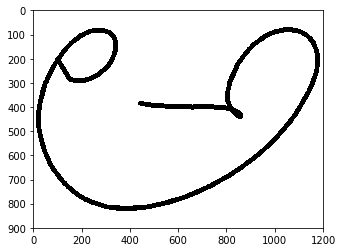

In [0]:
plot_image_single(input_paths['image_paths'] + 'Img/Sample001/img001-001.png')

---

### Sample Grid of the dataset images

---

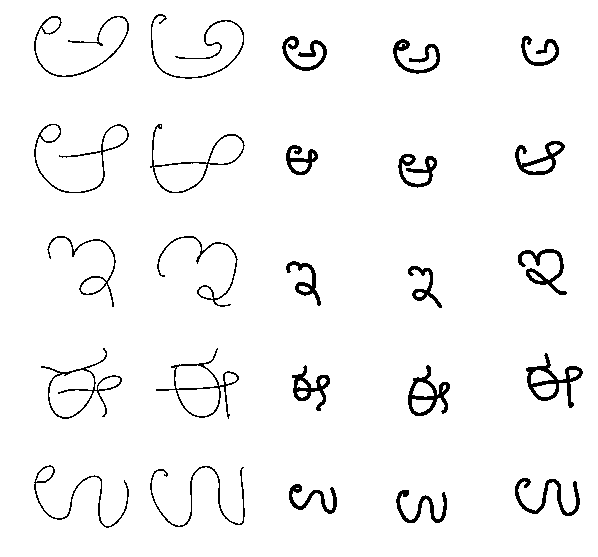

In [0]:
fig, axes = plt.subplots(5,5, figsize = (10, 10))
for i in range(5):
  for j in range(5):
    img=mpimg.imread(input_paths['image_paths'] + 'Img/Sample00'+str(i + 1)+'/img00'+str(i+1) + '-00'+ str(j+1)+'.png')
    axes[i, j].imshow(img)
    axes[i, j].axis('off')

## Data Preprocessing

In this section, we will try to make the handwritten images more similar to the class referred and the overall structure. The different tasks that will be performed in this section are:

- **Labelling the Data: **  Manual task of labelling the data as the data is unlabelled originally
- **Thinning the dark written images:** Make every image pixel width similar
- **Data Augmentations:** Augment the data as we need more data while training
- **Skewed -> Unskewed images:** Detecting and making the images unslanted
- **Noise removal:** Denoise the given images
- **Segmentation(if needed):**

As of now, we will do all the tasks of preprocessing tasks first and store them in the respective folder and then will try to label them all together.

Additionally for each of the preprocessing tasks, we will present the demo with one image of that kind. $ \underline {Visualisation \  of \ its \ working \ is \ a \ necessity.} $

---
### Thinning the image

---

Many a times, the pixel perimeter changes depending upon the thickness of the handwriting. In order to make all the handwritten images fall into the same thickness of the handwriting, we shall apply the thinning operation on the images.

For this purpose, **scikit-image** library provides a few methods *skeletonize_3d*, *skeletonize* and *thin* methods to tackle this need. Another method called *medial_axis* performs the same but keeps both skeleton and the medial axis of the image.

Click [here](https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html) for the documentation on the scikit-image.

In [0]:
def thinning(imagepath, need_to_store = False, isImage = True, max_iter_ = 20, output_path = ""):
  
    #-----Reads the image into grayscale-------------------#
    if isImage:
        image = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
        
    else:
        image = imagepath
    
    image = color.rgb2gray(image)
    image = invert(image)
    
    #-----thins the image with max iterations = 20---------#
    thin_1 = thin(image, max_iter = max_iter_)
    thin_1 = invert(thin_1)
    thin_1 = np.array(thin_1, dtype=np.uint8)
    (thresh, im_bw) = cv2.threshold(thin_1, 0, 255, cv2.THRESH_BINARY)
    if need_to_store:
      #-----Saving output image----------------------------#
      im = toimage(im_bw)
      #im= invert(im)
      if output_path == "":
          im.save(output_paths['image_paths'] + os.path.basename(imagepath))
      else:
          im.save(output_path)
          #print('thinned')
    else:
      #-----displays the image with binary colormap--------#
      plt.imshow(im_bw, cmap = 'binary')
      plt.show()

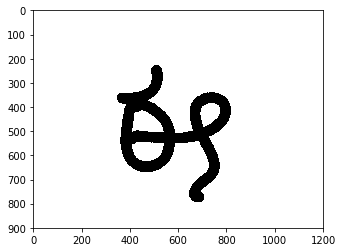

In [0]:
plot_image_single(input_paths['image_paths'] + 'Img/Sample004/img004-003.png')

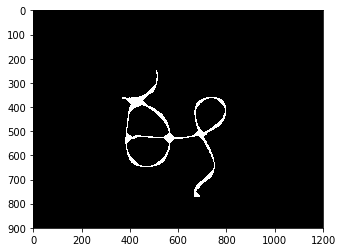

In [0]:
thinning(input_paths['image_paths'] + 'Img/Sample004/img004-003.png')

---
### Non-skewing the image

---

Follow the below process to rotate the images to the perfect angle

- Find the angle of the image
- Get the rotation matrix for that angle with the same number of rows and columns of original image
- Do Affine Transformation on the original image using the generated rotation matrix in step 2.

**What is an Affine Transformation?**
- Any transformation that can be expressed in the form of a matrix multiplication (linear transformation) followed by a vector addition (translation).


In [0]:
def unskew_image(imagepath, need_to_store = False, output_path = ""):
    img_1 = cv2.imread(imagepath)
    img = invert(img_1)
    height, width = img.shape[:2]
    
    #---Logic to find the angle of the image-------------------#
    data = []
    for j in range(0, width):
        col = img[:,j,:].sum(axis=1)
        sum_ = np.sum(col)
        if not sum_:
            continue

        for i in range(0, height):
            if col[i] > 0:
                data.append((j, i))
                break

    y_min, min_pos = None, None
    for idx, (x, y) in enumerate(data):
        if y_min is None or y < y_min:
            y_min = y
            min_pos = idx

    N = len(data)
    if min_pos > N - min_pos:
        data = data[:min_pos]
    else:
        data = data[min_pos:]

    data = np.asarray(data).T
    coefficients = np.polyfit(data[0], data[1], 1)
    #-----------converts the radians to degrees-----------------#
    alpha = math.atan(coefficients[0]) / math.pi * 180  
    
    ##----------Logic to rotate the matrix----------------------#
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), alpha, 1)
    
    img_rotation = cv2.warpAffine(img, rotation_matrix, (width, height))
    img_rotation = invert(img_rotation)
    
    if not need_to_store:
      ##----------show the image--------------------------------#
      fig, axs = plt.subplots(1, 2, figsize = (10, 10))
      axs[1].imshow(img_rotation)
      axs[0].imshow(img_1)
    else:
      ##----------save the image--------------------------------#
      im = toimage(img_rotation)
      if output_path == "":
          im.save(output_paths['image_paths'] + os.path.basename(imagepath))
      else:
          im.save(output_path)
          #print("unskewed")

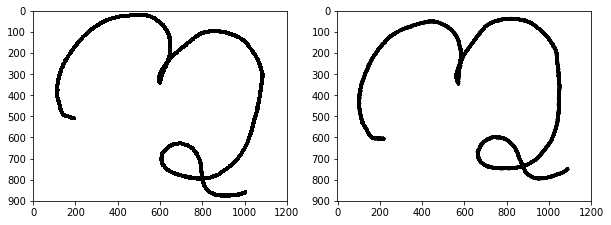

In [0]:
unskew_image(input_paths['image_paths'] + 'Img/Sample003/img003-002.png')

In [0]:
unskew_image(input_paths['image_paths'] + 'Img/Sample003/img003-002.png', True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


---
### Noise removal from the image

---

Sometimes, in the image, there is a possibility to find noise. Noise hinders the prediction as it interrupts in the pixel matrix calculations. Hence, it becomes important to remove the noise from the given image before applying the model on it. 

To remove the noise, we will use the *fastNlMeansDenoisingColored* module available under *cv2* library.

$\underline {Note}$: To fill the noise data with the relevant periphery pixel values through training, we can use autoencoders. But, as the use of autoencoders for noise removal is out of scope, we will go with the basic method of removing the noise.

In [0]:
def noise_removal(imagepath, need_to_store = False, output_path = ""):
    img = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
    #--------- Remove the noise from the image ---------#
    noise_removed = cv2.fastNlMeansDenoising(img, None, 40, 7, 21)#, 21)
    (thresh, im_bw) = cv2.threshold(noise_removed, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    if need_to_store:
        #---------- Save the noise free image ----------#
        #os.path.splitext(imagepath)[0]
        im = toimage(im_bw)
        if output_path == "":
          im.save(output_paths['image_paths'] + os.path.basename(imagepath))
        else:
          im.save(output_path)
          #print("denoised")
        #cv2.imwrite(imagepath, dst)
    else:
        #----------- Show the noise free image ---------#
        plt.imshow(noise_removed, cmap = 'binary')
        plt.show()

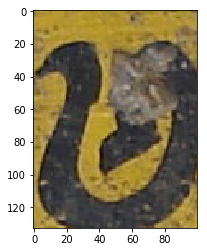

In [0]:
plot_image_single(input_paths['image_paths'] + 'img001-00006.png')

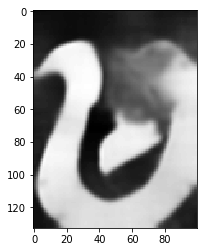

In [0]:
noise_removal(input_paths['image_paths'] + 'img001-00006.png')

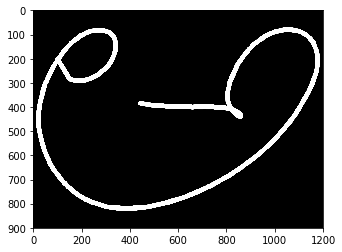

In [0]:
noise_removal('/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-001.png')

---
**Binarize the image**

---

All the images given here are colored images. They appear to be handwritten images with black and white color map but are colored. 

As we are working on grayscaled images, we will try to binarize the given images into grayscaled images.

$\underline{Note:}$ Binarized here means the pixel values will be either 0 or 1.

In [0]:
def binarize_image(imagepath, need_to_store = False):
    pass

---
### Image cropping

---

In the images dataset, images are not always in the best of the possible manner. Many a times, the important content remains small and the rest is just a plain-white background. In order to make the content more relevant and useful, we will apply image cropping on the given image dataset wherever required.

Steps to cropping an image through Python:

- Read the image
- Find the bounding box 
- Crop the image using the bounding box boundary  co-ordinates.
- Show/Save the image

In [0]:
def crop_image(imagepath, need_to_store = False, output_path = ""):

    #------------ Reading the given image --------------------#
    img = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE) 
    img = color.rgb2gray(img)
    #img = invert(img)
    #------------ Threshold conversion on the given image --------------#
    #retval, thresh_gray = cv2.threshold(img, thresh=100, maxval=255, type=cv2.THRESH_BINARY)

    #------------ Finding the bounding box co-ordinates ----------------#
    points = np.argwhere(img==0) # find where the black pixels are
    points = np.fliplr(points) # store them in x,y coordinates instead of row,col indices
    x, y, w, h = cv2.boundingRect(points) # create a rectangle around those points
    x, y, w, h = x-10, y-10, w+20, h+20 # make the box a little bigger
    
    try:
      crop = img[y:y+h, x:x+w] # create a cropped region of the gray image
    except:
      crop = img

    # get the thresholded crop
    #retval, thresh_crop = cv2.threshold(crop, thresh=200, maxval=255, type=cv2.THRESH_BINARY)

    if need_to_store:
        #---------- Save the noise free image ----------#
        #os.path.splitext(imagepath)[0]
        try:
          im = toimage(crop)
        except:
          im = toimage(img)
        if output_path == "":
            im.save(output_paths['image_paths'] + os.path.basename(imagepath))
        else:
            im.save(output_path)
            #print('cropped')
        #im.save('/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/temp_crop1.png')
        #cv2.imwrite(imagepath, dst)
    else:
        #----------- Show the noise free image ---------#
        plt.imshow(crop, cmap = 'binary')
        plt.show()

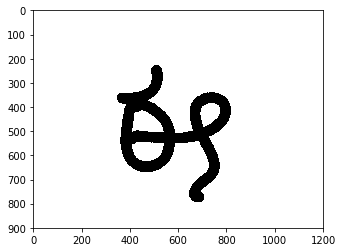

In [0]:
plot_image_single(input_paths['image_paths'] + 'Img/Sample004/img004-003.png')

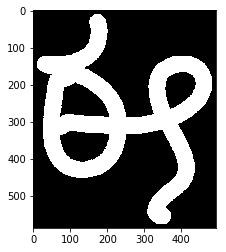

In [0]:
crop_image(input_paths['image_paths'] + 'Img/Sample004/img004-003.png')

In [0]:
crop_image(input_paths['image_paths'] + 'Img/Sample004/img004-003.png', True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


---
### Sample resizing of the image

---

This particular piece of code is meant to show, how the image can be resized into an appropriate size.

As of now, we will be using the resizing of height 28 and width 28

In [0]:
def img_resize(imagepath):
    
    img = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
    img = invert(img)
    img_resized = cv2.resize(img, (50, 50), interpolation = cv2.INTER_CUBIC)
    
    fig, axes = plt.subplots(1, 2, figsize= (10, 10))
    axes[0].imshow(img, cmap = 'binary')
    #axes[0].axis('off')
    axes[1].imshow(img_resized, cmap = 'binary')
    #axes[1].axis('off')

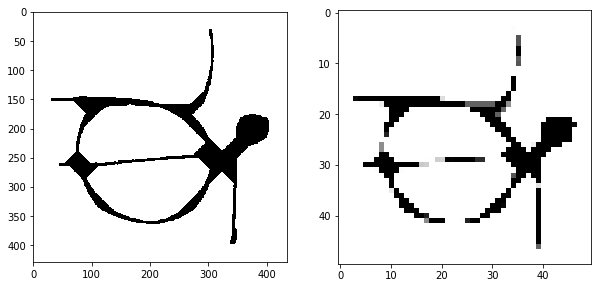

In [0]:
img_resize(output_paths['image_paths'] + 'Sample4/img004-007.png')

---
### Executing the complete flow of all preprocessing tasks

---

Now, it's time to create a pipeline of the preprocessing tasks created and displayed above. The flow will be as below:

- Remove the noise
- Unskew the image
- Crop the image
- Thinning the image
- Resize if needed.



In [0]:
## Don't run this cell.

---
### Applying the transformation on the original dataset

---

In [0]:
character_mapping_list = ["A","Aa","E","Ee","U","Uu","Ru","Ruu","Yeh","Yeeh","I","O","Oo","Au","Aum","Aaha","Ka","Kha","Ga","Gha","Gnya","Cha","Chha","Jha","Jhha","Nya","Ta","Tta","Da","Dda","Nna","Tha","Thha","Da","Dha","Na","Pa","Pha","Ba","Bha","Ma","Ya","Ra","La","Lah","Va","She","Sha","Sa","Ha","0","1","2","3","4","5","6","7","8","9"]

In [0]:
folder_char_mapping = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,35,52,69,86,103,120,137,154,171,188,205,222,239,256,273,290,307,324,341,358,375,392,409,426,443,460,494,511,545,562,579,596,613,648,649,650,651,652,653,654,655,656,657]

In [0]:
def final_pipeline():
    all_files =[]
    with open(input_paths['list_file']) as op:
        all_files = op.readlines()
    counter = 0
    #-------- Every Folder has 25 files in the dataset ---------#
    for index, abs_path in enumerate(all_files):
        mod_ = (index%25) + 1
        
        if mod_ == 1:
            counter+= 1
            if counter in folder_char_mapping:
                if 'Sample' + str(counter) in os.listdir(output_paths['image_paths']):
                    pass
                else:
                    os.mkdir(output_paths['image_paths'] + 'Sample' + str(counter))
            else:
                pass
        else:
            pass
        if counter in folder_char_mapping:
            op_path = output_paths['image_paths'] + 'Sample' + str(counter) + '/' + os.path.basename(abs_path).strip()
            print(input_paths['image_paths'] + abs_path.strip())
            noise_removal(input_paths['image_paths'] + abs_path.strip(), need_to_store = True, output_path = op_path)
            #unskew_image(op_path, need_to_store = True, output_path = op_path)
            crop_image(op_path, need_to_store = True, output_path = op_path)
            thinning(op_path, need_to_store = True, isImage = True, max_iter_ = 20, output_path = op_path)
        else:
            pass


        

In [0]:
final_pipeline()

/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-001.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-002.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-003.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-004.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-005.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-006.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-007.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-008.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-009.png
/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/Hnd/Img/Sample001/img001-010.png
/content/gdrive/My Drive/Colab Notebooks

---
### Labelling the data

---

After preprocessing the original dataset into the images for 60 class of character and numbers, we finally could label it.

For labelling, we will use the **'pickle'** library for the same. Additionally, the images will be adjusted into dimensions of (50\*50). 

The label mapping directory declared previously will be used

In [0]:
import pickle
from imutils import paths
from random import shuffle

In [0]:
from IPython.display import clear_output

In [0]:
def label_data(path_):
    data, data_shuffled = [], []
    labels, labels_shuffled = [], []
    
    ##-------- Labelling the dataset -------------##
    for index, dir_name in enumerate(os.listdir(path_)):
        
        file_names = os.listdir(path_+ dir_name)
        
        for file_name in file_names:
          
          filepath_ = path_ + dir_name + '/' + file_name
          
          img_grayscale = cv2.imread(filepath_, cv2.IMREAD_GRAYSCALE)
          img_grayscale = cv2.resize(img_grayscale, (50, 50), interpolation = cv2.INTER_CUBIC)
          print("Done with -> ", filepath_)
          data.append(img_grayscale)
          labels.append(index)
    
    ##-------- I need to shuffle the data ---------##
    '''It is very important to shuffle the dataset to let the model learn 
       in a better way'''
    
    
    index_data = list(range(len(data)))
    shuffle(index_data) ## in place operation
    
    clear_output(wait = True)
    print("-----Started shuffling----")
    for index_ in index_data:
        data_shuffled.append(data[index_])
        labels_shuffled.append(labels[index_])
    
    ##-------- Array conversion: Important for tensorflow models --------##
    data_shuffled = np.array(data_shuffled)
    labels_shuffled = np.array(labels_shuffled)
    data_shuffled = data_shuffled.reshape((data_shuffled.shape[0], 50 * 50))
    print(data_shuffled.shape)
    print(labels_shuffled.shape)
    
    with open('/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/kannada_chars.pickle', 'wb') as pf:
        pickle.dump([data_shuffled, labels_shuffled], pf)

In [0]:
label_data(output_paths['image_paths'])

-----Started shuffling----
(1441, 2500)
(1441,)


---
## Data loading

---

These days, the datasets are preloaded in the TensorFlow or Keras frameworks. In our case, we have tried to load the dataset into a pickle file. 

**What is a pickle file?**

- A file which stores the data that can be used in the later stage using the load method. Try to relate it to the informal meaning of pickle in English, will be easier to understand.

- It is used to store the python objects into a database. As the numpy arrays are objects of numpy class, we can serialise it and store it. Retrieve it whenever needed



In [0]:
def load_pickle_data(picklefilepath_, ml_dl = 1):  ##ml_dl means machine learning or deep learning framework/algo used. If ml, leave the loaded values as it is.
    
    ##---------- Assuming that the size of the pickle > 0 in bits -------------##
    ##---------- rb = read binary -----------##
    with open(picklefilepath_, 'rb') as pd:
      data, labels = pickle.load(pd)
    
    
    ##---------- Train Test split -------------- ##
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2)
    
    if ml_dl == 1:
        ##---------- Reshaping the data 50*50 dimension. Grayscale ==>channels = 1 -------##
        x_train = x_train.reshape(x_train.shape[0], 50, 50, 1)
        x_test = x_test.reshape(x_test.shape[0], 50, 50, 1)

        ##---------- datatype to be converted to float32 ----------- ##
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')


        x_train /= 255
        x_test /= 255

        ## Reference  - Keras documentation ---------------##
        y_train = keras.utils.to_categorical(y_train, len(character_mapping_list))
        y_test = keras.utils.to_categorical(y_test, len(character_mapping_list))
        
    elif ml_dl == 2:
      ##---------- Reshaping the data 50*50 dimension. Grayscale ==>channels = 3 -------##
        x_train = x_train.reshape(x_train.shape[0], 50, 50)
        x_test = x_test.reshape(x_test.shape[0], 50, 50)

        ##---------- datatype to be converted to float32 ----------- ##
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')


        x_train /= 255
        x_test /= 255

        ## Reference  - Keras documentation ---------------##
        y_train = keras.utils.to_categorical(y_train, len(character_mapping_list))
        y_test = keras.utils.to_categorical(y_test, len(character_mapping_list))
        
    else:
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        
        x_train /= 255  ##<------ Normalise the train values
        x_test /= 255   ##<------ Normalise the test values
        
       
    return x_train, y_train, x_test, y_test


## Naive Machine Learning Algorithms

Some of the algorithms like k - Nearest neighbors, Support Vector Machine and Boosting algorithms will work for image classification problems.

In this project, we will experiment with 
- K-Nearest Neighbors
- Support Vector Machine
- Gradient Boosting Algorithm like ______, ______

### K-Nearest Neighbor Algorithm

K-Nearest Neighbor algorithm is a computationally heavy algorithm as it is a lazy learning algorithms.
The parameter of n_neighbors can be fine tuned to achieve the best possible accuracy.

---
**Loading the data from the pickle file -  ml algorithms compatible**

---

In [0]:
x_train, y_train, x_test, y_test = load_pickle_data('/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/kannada_chars.pickle', 0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1152, 2500)
(289, 2500)
(1152,)
(289,)


---
**Training and Validating the model**

---

We will try with different values of neighbors viz. 5, 9, 15, 21.

In [0]:
knn_obj = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)
knn_obj.fit(x_train, y_train)
y_pred = knn_obj.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.75      0.50         4
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.67      0.50      0.57         4
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.50      0.40      0.44         5
           9       0.50      0.29      0.36         7
          10       0.50      0.40      0.44         5
          11       0.02      1.00      0.04         4
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         2
          16       1.00      0.25      0.40         4
          17       0.00    

---
### SVM - Support Vector Machine

---

In [0]:
svm_object = SVC(kernel = 'poly', degree = 5)
svm_object.fit(x_train, y_train)
y_pred_svm = svm_object.predict(x_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         4
          17       0.00    

----
## Deep Neural Networks - Convolutional Networks

---
As the problem we are  dealing right now is a part of the image classification, we will be using the convolutional neural network to complete the prediction task.

For the convolutional neural network, I will be dealing with the different optimizers and kernel sizes.
It very essential to experiment through hyper-parameter tuning and regularization.



---
**Plotting Graph Class**

---

In [0]:
def plott_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
class RecordLossGraph(keras.callbacks.Callback):
  
    def __init__(self):
          pass
          #self.imagepath = ipath_
          #self.loss_df = pd.DataFrame(columns = ["Epoch Number", "Training Loss", "Validation Loss"])
          #self.loss_df.set_index('Epoch Number')
    def on_train_begin(self, logs={}):
          # Initialize the lists for holding the logs, losses and accuracies
          self.losses = []
          self.acc = []
          self.val_losses = []
          self.val_acc = []
          self.logs = []
          
    # This function is called at the end of each epoch
    '''def on_epoch_end(self, epoch, logs={}):
          
          self.logs.append(logs)
          self.losses.append(logs.get('loss'))
          self.acc.append(logs.get('acc'))
          self.val_losses.append(logs.get('val_loss'))
          self.val_acc.append(logs.get('val_acc'))
          
          #self.loss_df['Epoch Number'] = range(1, epoch+1, 1)
          self.loss_df = self.loss_df.append({'Epoch Number': int(epoch), 'Training Loss': logs.get('loss'), 'Validation Loss': logs.get('val_loss')}, ignore_index = True)
          #self.loss_df['Training Loss'] = self.losses
          #self.loss_df['Validation Loss'] = self.val_losses
          clear_output(wait = True)
          print(self.loss_df)'''
          
    # This function is called at the end of training      
    def on_train_end(self, logs):
          
          loss_labels = np.arange(0, len(self.losses))
          plt.figure()
          plt.plot(loss_labels, self.losses, label = "train_loss")
          #plt.plot(loss_labels, self.acc, label = "train_acc")
          plt.plot(loss_labels, self.val_losses, label = "val_loss")
          #plt.plot(loss_labels, self.val_acc, label = "val_acc")
          plt.title("Training Loss and Accuracy [Epoch {}]".format(len(self.losses)))
          plt.xlabel("Epoch number")
          plt.ylabel("Loss")
          plt.legend()
          plt.show()
          #plt.savefig(self.imagepath + '.jpg')
          #plt.close()

In [0]:
x_train, y_train, x_test, y_test = load_pickle_data('/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/kannada_chars.pickle', 1)

---
**Generalised classes**

---

In [0]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [0]:
from sklearn.metrics import f1_score
def modelling(path, x_test, y_test):
    model = load_model(path)
    y_pred_tf = model.predict(x_test)
    true_classes = np.argmax(y_test, axis = 1)
    predicted_classes = np.argmax(y_pred_tf, axis = 1)
    cm = confusion_matrix(true_classes, predicted_classes)
    plot_confusion_matrix(cm, np.unique(true_classes))
    print(f1_score(true_classes, predicted_classes, average = 'weighted'))
    #print(classification_report(true_classes, predicted_classes))

---
**Experiment - 1**

---

Train on 1152 samples, validate on 289 samples
Epoch 1/100
1152/1152 [==============================] - 18s 15ms/step - loss: 4.0991 - val_loss: 4.0537
Epoch 2/100
1152/1152 [==============================] - 17s 15ms/step - loss: 2.8403 - val_loss: 1.5991
Epoch 3/100
1152/1152 [==============================] - 17s 15ms/step - loss: 1.0022 - val_loss: 0.9804
Epoch 4/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.5715 - val_loss: 0.8610
Epoch 5/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.3060 - val_loss: 0.7371
Epoch 6/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1770 - val_loss: 0.8873
Epoch 7/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1463 - val_loss: 0.8159
Epoch 8/100
1152/1152 [==============================] - 17s 14ms/step - loss: 0.0979 - val_loss: 0.6435
Epoch 9/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0513 - val_loss: 0.6741
Epoch 10

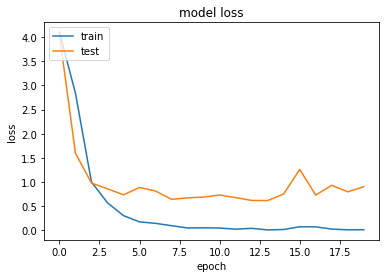

Train on 1152 samples, validate on 289 samples
Epoch 1/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.0776 - val_loss: 0.9873
Epoch 2/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.0528 - val_loss: 0.9141
Epoch 3/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0299 - val_loss: 1.0592
Epoch 4/100
1152/1152 [==============================] - 17s 14ms/step - loss: 0.0350 - val_loss: 0.8190
Epoch 5/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.0043 - val_loss: 0.8969
Epoch 6/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0148 - val_loss: 1.0784
Epoch 7/100
1152/1152 [==============================] - 17s 14ms/step - loss: 0.0539 - val_loss: 0.8885
Epoch 8/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.0612 - val_loss: 0.6966
Epoch 9/100
1152/1152 [==============================] - 15s 13ms/step - loss: 0.0519 - val_loss: 1.0099
Epoch 10

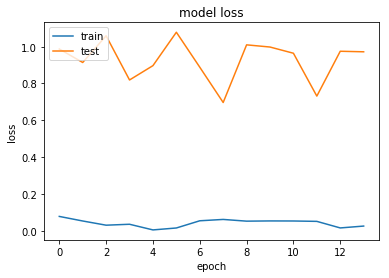

Train on 1152 samples, validate on 289 samples
Epoch 1/100
1152/1152 [==============================] - 15s 13ms/step - loss: 0.0268 - val_loss: 1.2493
Epoch 2/100
1152/1152 [==============================] - 14s 12ms/step - loss: 0.0197 - val_loss: 1.0424
Epoch 3/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0614 - val_loss: 0.9086
Epoch 4/100
1152/1152 [==============================] - 15s 13ms/step - loss: 0.0256 - val_loss: 1.3518
Epoch 5/100
1152/1152 [==============================] - 14s 12ms/step - loss: 0.0300 - val_loss: 1.0367
Epoch 6/100
1152/1152 [==============================] - 15s 13ms/step - loss: 0.0231 - val_loss: 1.1040
Epoch 7/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0128 - val_loss: 1.1821
Epoch 8/100
1152/1152 [==============================] - 15s 13ms/step - loss: 0.0115 - val_loss: 1.0290
Epoch 9/100
1152/1152 [==============================] - 14s 13ms/step - loss: 0.0139 - val_loss: 0.9299
Epoch 00

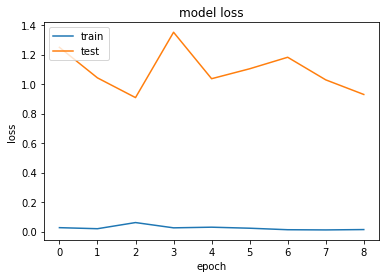

In [0]:
model = Sequential()
model.add(Conv2D(64, (5, 5), padding="same", input_shape=(50, 50, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(50, (5, 5), padding="same", input_shape=(50, 50, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Conv2D(32, (5, 5), padding="same", input_shape=(50, 50, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(60, activation='softmax'))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6, verbose=2, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights_cnn1.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(3):
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    history = model.fit(x_train, y_train, validation_data= (x_test, y_test),
                          callbacks=[monitor,checkpointer], verbose=1,epochs=100)
    plott_loss(history)

0.842230883529479


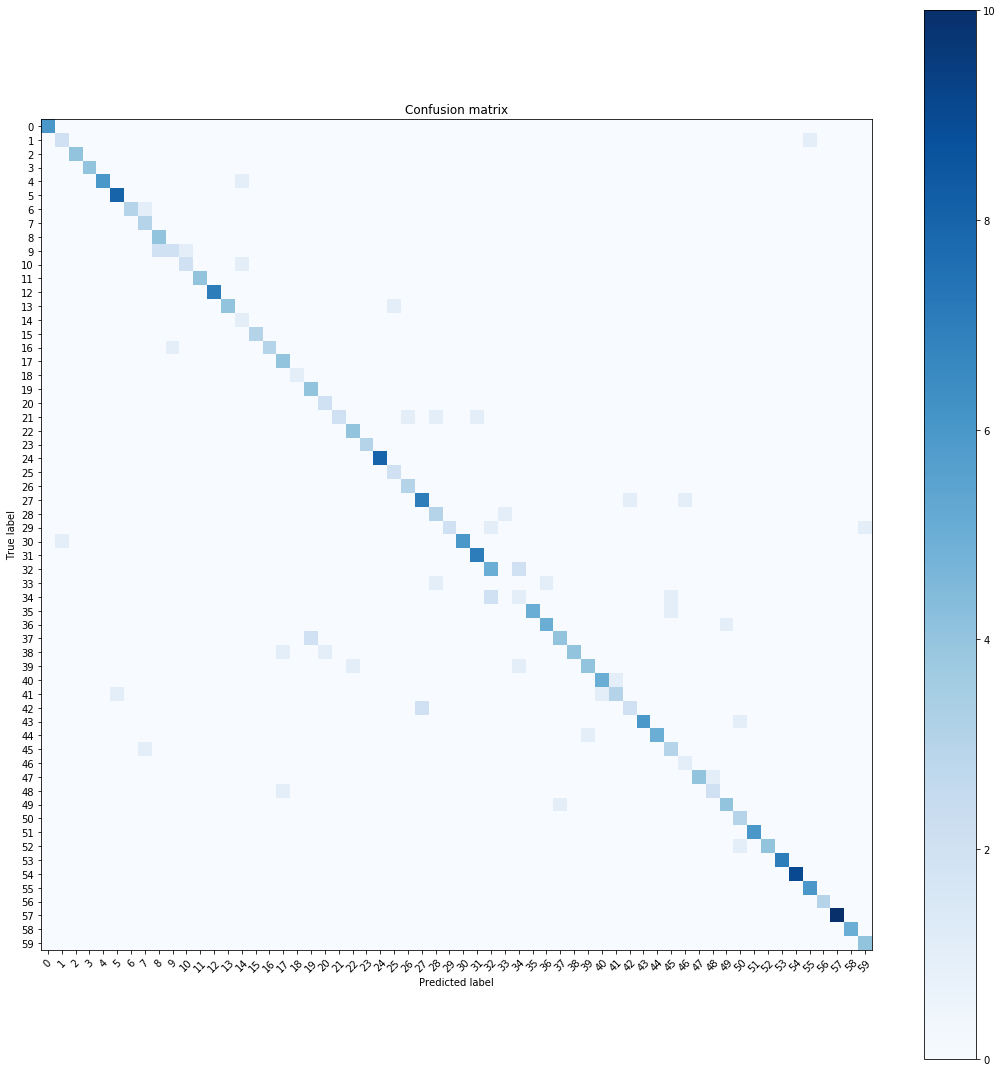

In [0]:
modelling('best_weights_cnn1.hdf5', x_test, y_test)

---
**Experiment -2**

---

In this experiment, we will try to apply **leaky relu** instead of relu as the activation function. Leaky relu is somewhat flexible w.r.t the ReLU activation function.

In [0]:
from keras.layers import LeakyReLU

In [0]:
model = Sequential()
model.add(Conv2D(50, (5, 5), padding="same", input_shape=(50, 50, 1)))
model.add(LeakyReLU(alpha = 0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (5, 5), padding="same", input_shape=(50, 50, 1)))
model.add(LeakyReLU(alpha = 0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Conv2D(32, (5, 5), padding="same", input_shape=(50, 50, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(60, activation='softmax'))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6, verbose=2, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights_cnn1.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(3):
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    history = model.fit(x_train, y_train, validation_data= (x_test, y_test),
                          callbacks=[monitor,checkpointer], verbose=1,epochs=100)
    plott_loss(history)

0.866621229597008


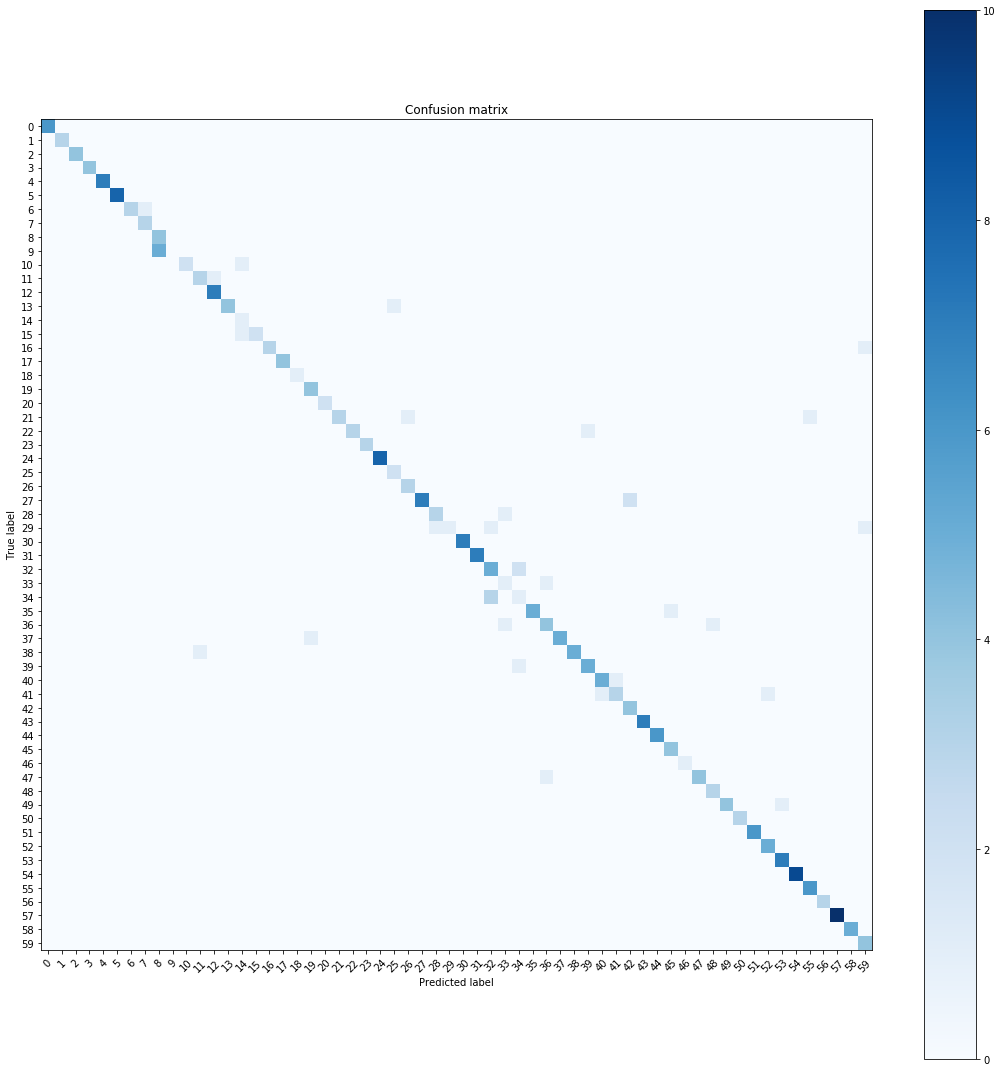

In [0]:
modelling('best_weights_cnn1.hdf5', x_test, y_test)

---
**Experiment -3**

---

In this experiment, we will try to use the optimizer as 'AdaGrad and rmsprop'. Both of these works better in case of image recognition. We will try to optimize the model, change the structure too at the same time.

Train on 1152 samples, validate on 289 samples
Epoch 1/100
1152/1152 [==============================] - 20s 17ms/step - loss: 4.1055 - val_loss: 4.0238
Epoch 2/100
1152/1152 [==============================] - 17s 14ms/step - loss: 3.3642 - val_loss: 1.7357
Epoch 3/100
1152/1152 [==============================] - 17s 15ms/step - loss: 1.5060 - val_loss: 0.9622
Epoch 4/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.9355 - val_loss: 0.6416
Epoch 5/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.6918 - val_loss: 0.6509
Epoch 6/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.5016 - val_loss: 0.6993
Epoch 7/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.3833 - val_loss: 0.5488
Epoch 8/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.3378 - val_loss: 0.5453
Epoch 9/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.3722 - val_loss: 0.5361
Epoch 10

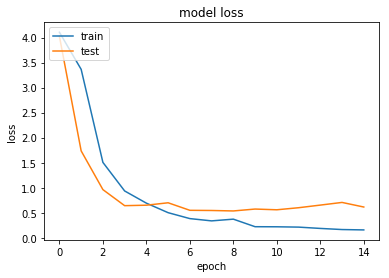

Train on 1152 samples, validate on 289 samples
Epoch 1/100
1152/1152 [==============================] - 20s 17ms/step - loss: 0.2092 - val_loss: 0.5775
Epoch 2/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1752 - val_loss: 0.6606
Epoch 3/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1743 - val_loss: 0.8024
Epoch 4/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1820 - val_loss: 0.6509
Epoch 5/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1446 - val_loss: 0.9547
Epoch 6/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.1185 - val_loss: 0.5836
Epoch 7/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1090 - val_loss: 0.7491
Epoch 00007: early stopping


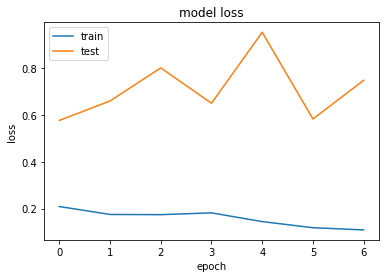

Train on 1152 samples, validate on 289 samples
Epoch 1/100
1152/1152 [==============================] - 19s 17ms/step - loss: 0.1632 - val_loss: 0.8105
Epoch 2/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.1607 - val_loss: 0.7595
Epoch 3/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.1098 - val_loss: 0.8736
Epoch 4/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.0885 - val_loss: 0.6115
Epoch 5/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0982 - val_loss: 0.7371
Epoch 6/100
1152/1152 [==============================] - 17s 14ms/step - loss: 0.1189 - val_loss: 0.6384
Epoch 7/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.2086 - val_loss: 0.9502
Epoch 8/100
1152/1152 [==============================] - 17s 14ms/step - loss: 0.1848 - val_loss: 0.7475
Epoch 9/100
1152/1152 [==============================] - 17s 15ms/step - loss: 0.2009 - val_loss: 0.7972
Epoch 10

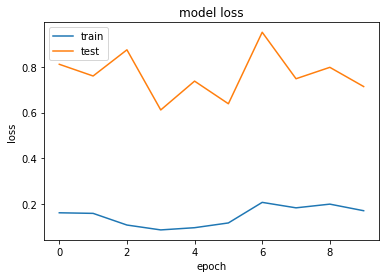

In [0]:
model = Sequential()
model.add(Conv2D(50, (5, 5), padding="same", input_shape=(50, 50, 1), activation = 'tanh'))
#model.add(LeakyReLU(alpha = 0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (5, 5), padding="same", input_shape=(50, 50, 1), activation='tanh'))
#model.add(LeakyReLU(alpha = 0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Conv2D(32, (5, 5), padding="same", input_shape=(50, 50, 1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(500))

model.add(Dense(60, activation='softmax'))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6, verbose=2, mode='auto') 
checkpointer = ModelCheckpoint(filepath="best_weights_cnn1.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(3):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
    history = model.fit(x_train, y_train, validation_data= (x_test, y_test),
                          callbacks=[monitor,checkpointer], verbose=1,epochs=100)
    plott_loss(history)

0.8406991781969018


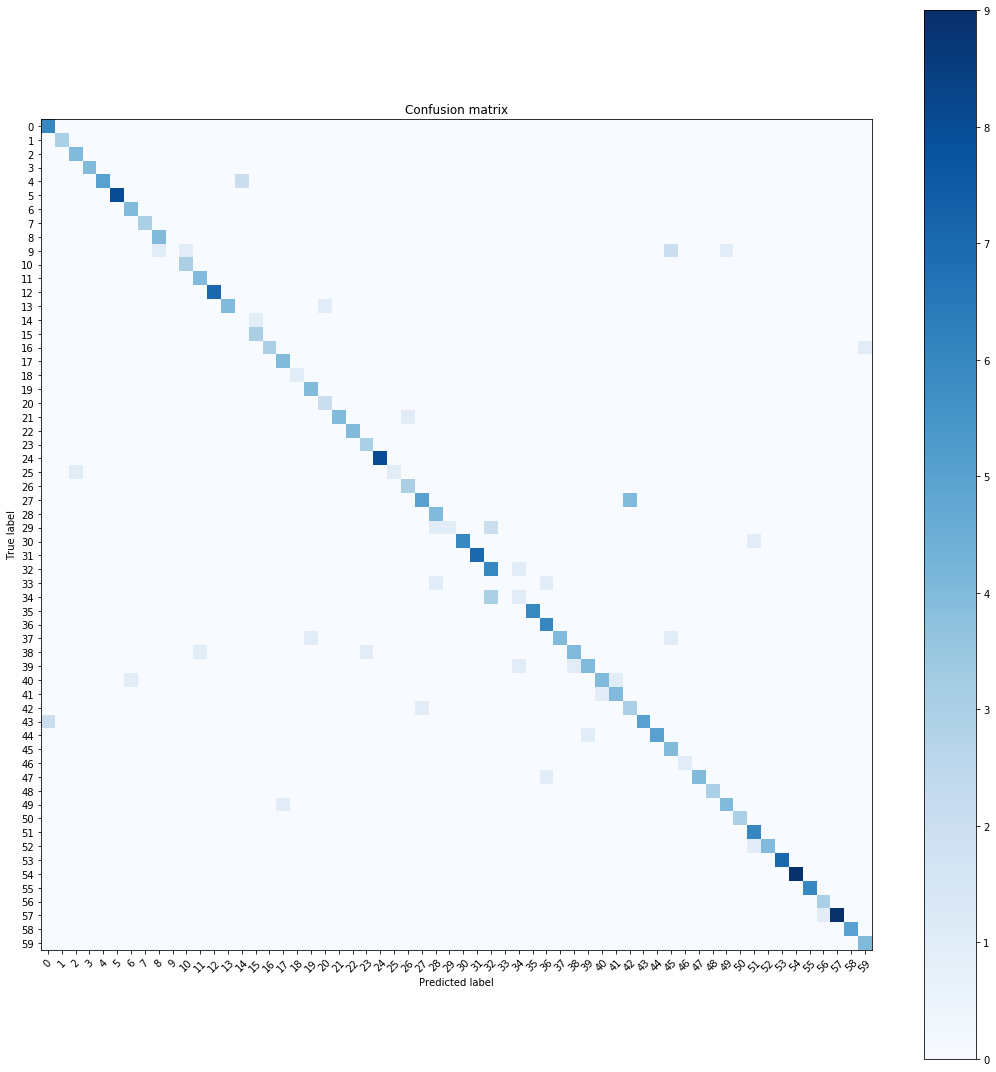

In [0]:
modelling('best_weights_cnn1.hdf5', x_test, y_test)

---
**There are a lot of experiments that can be done, but considering the time constraint, we will stop on the current experiment. We will then try to move to the next experiments that include:**
- Transfer learning
- Applying the best of the model to a different dataset for e.g. hindi dataset

---

---
## Transfer Learning

---
Transfer learning is useful when we have less data and we want to make the most out of the low level features. In our case, we will try to apply transfer learning using two of the pretrained models to see if using a pretrained model can help us achieve some good accuracy.

It's a part of the experiment here. Using transfer learning might not help all the time.

We are using th Fine tune approach. In fine tune approach, we will try to freeze the previous layers and add our layers at the end.



In [0]:
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

---
**Using a DenseNet Model**

---

In [0]:
base_model=DenseNet121(input_shape=(50,50,3),weights='imagenet',include_top=False) 
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(60,activation='softmax')(x) #final layer with softmax activation

29089792/29084464 [==============================] - 0s 0us/step


---
**Loading the data from the pickle file**

---

In [0]:
x_train, y_train, x_test, y_test = load_pickle_data('/content/gdrive/My Drive/Colab Notebooks/data 215/data/Kannada/kannada_chars.pickle', 2)

---
**Converting the grayscale images to RGB using np.repeat**

---

In [0]:
rgb_batch = np.repeat(x_train[..., np.newaxis], 3, -1) 
rgb_batch_test = np.repeat(x_test[..., np.newaxis], 3, -1) 
print(rgb_batch_test.shape)
print(rgb_batch.shape)

(289, 50, 50, 3)
(1152, 50, 50, 3)


In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [0]:
for layer in base_model.layers:
    layer.trainable=False
# or if we want to set the first 86 layers of the network to be non-trainable
for layer in base_model.layers[:427]:
    layer.trainable=False
for layer in base_model.layers[427:]:
    layer.trainable=True

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
train_generator = ImageDataGenerator()
train_generator.fit(rgb_batch)

model_info = model.fit_generator(train_generator.flow(rgb_batch, y_train, batch_size=1),
steps_per_epoch=len(rgb_batch) / 1, epochs=25, 
validation_data=(rgb_batch_test, y_test))


Epoch 1/25
1152/1152 [==============================] - 99s 86ms/step - loss: 4.0945 - acc: 0.0182 - val_loss: 4.2317 - val_acc: 0.0173
Epoch 2/25
1152/1152 [==============================] - 91s 79ms/step - loss: 4.0916 - acc: 0.0182 - val_loss: 4.2328 - val_acc: 0.0173
Epoch 3/25
1152/1152 [==============================] - 94s 82ms/step - loss: 4.0913 - acc: 0.0191 - val_loss: 4.2341 - val_acc: 0.0173
Epoch 4/25
1152/1152 [==============================] - 96s 83ms/step - loss: 4.0911 - acc: 0.0174 - val_loss: 4.2354 - val_acc: 0.0173
Epoch 5/25
1152/1152 [==============================] - 94s 82ms/step - loss: 4.0911 - acc: 0.0182 - val_loss: 4.2364 - val_acc: 0.0173
Epoch 6/25
1152/1152 [==============================] - 95s 82ms/step - loss: 4.0909 - acc: 0.0182 - val_loss: 4.2376 - val_acc: 0.0173
Epoch 7/25
1152/1152 [==============================] - 94s 82ms/step - loss: 4.0909 - acc: 0.0200 - val_loss: 4.2383 - val_acc: 0.0138
Epoch 8/25
1152/1152 [==========================

---
**Using a ResNet Model**

---

In [0]:
base_model1=ResNet50(input_shape=(50,50,3),weights='imagenet',include_top=False) 
x=base_model1.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.5)(x) 
x=Dense(256,activation='relu')(x)
x = Dropout(0.5)(x)
preds=Dense(60,activation='softmax')(x) #final layer with softmax activation

In [0]:
modelrs=Model(inputs=base_model1.input,outputs=preds)

In [0]:
for i,layer in enumerate(modelrs.layers):
  print(i,layer.name)

0 input_4
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_132
5 pool1_pad
6 max_pooling2d_39
7 res2a_branch2a
8 bn2a_branch2a
9 activation_133
10 res2a_branch2b
11 bn2a_branch2b
12 activation_134
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_33
18 activation_135
19 res2b_branch2a
20 bn2b_branch2a
21 activation_136
22 res2b_branch2b
23 bn2b_branch2b
24 activation_137
25 res2b_branch2c
26 bn2b_branch2c
27 add_34
28 activation_138
29 res2c_branch2a
30 bn2c_branch2a
31 activation_139
32 res2c_branch2b
33 bn2c_branch2b
34 activation_140
35 res2c_branch2c
36 bn2c_branch2c
37 add_35
38 activation_141
39 res3a_branch2a
40 bn3a_branch2a
41 activation_142
42 res3a_branch2b
43 bn3a_branch2b
44 activation_143
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_36
50 activation_144
51 res3b_branch2a
52 bn3b_branch2a
53 activation_145
54 res3b_branch2b
55 bn3b_branch2b
56 activation_146
57 res3b_branch2c
58 bn3b_branch2c
59 add_37
60 activation_147
61 

In [0]:
for layer in modelrs.layers[:-6]:
    layer.trainable = False

In [0]:
modelrs.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_info = modelrs.fit(rgb_batch, y_train, batch_size=1, epochs=25, validation_data=(rgb_batch_test, y_test))

Train on 1152 samples, validate on 289 samples
Epoch 1/25
1152/1152 [==============================] - 108s 94ms/step - loss: 4.2235 - acc: 0.0174 - val_loss: 4.2001 - val_acc: 0.0208
Epoch 2/25
1152/1152 [==============================] - 94s 82ms/step - loss: 4.1682 - acc: 0.0174 - val_loss: 4.2142 - val_acc: 0.0104
Epoch 3/25
1152/1152 [==============================] - 92s 80ms/step - loss: 4.0919 - acc: 0.0295 - val_loss: 4.5240 - val_acc: 0.0104
Epoch 4/25
1152/1152 [==============================] - 91s 79ms/step - loss: 4.0368 - acc: 0.0503 - val_loss: 4.8278 - val_acc: 0.0104
Epoch 5/25
1152/1152 [==============================] - 90s 78ms/step - loss: 3.8745 - acc: 0.0851 - val_loss: 5.5465 - val_acc: 0.0173
Epoch 6/25
1152/1152 [==============================] - 91s 79ms/step - loss: 3.6702 - acc: 0.1215 - val_loss: 6.4799 - val_acc: 0.0035
Epoch 7/25
1152/1152 [==============================] - 92s 80ms/step - loss: 3.5332 - acc: 0.1476 - val_loss: 7.2917 - val_acc: 0.0173


0.0007237061793095578


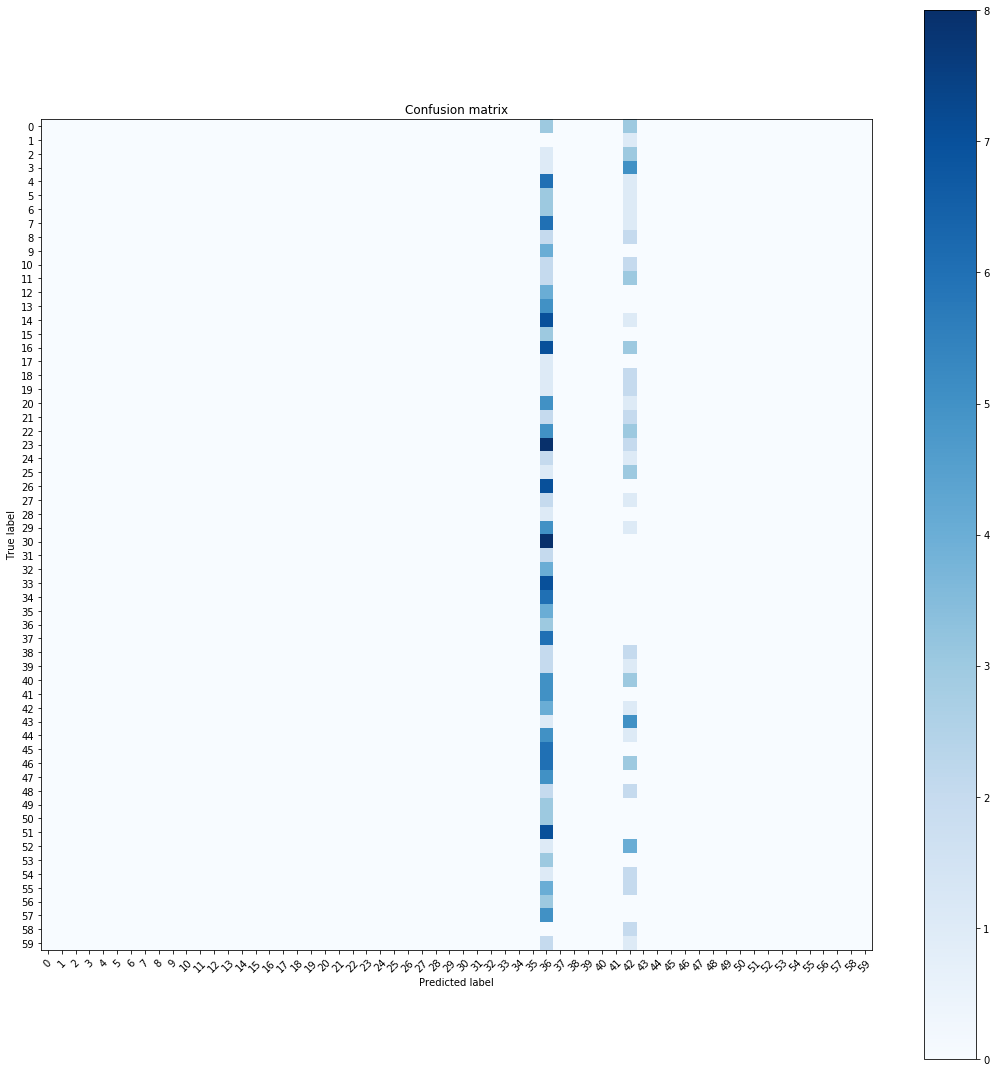

In [0]:
y_pred_tf = modelrs.predict(rgb_batch_test)
true_classes = np.argmax(y_test, axis = 1)
predicted_classes = np.argmax(y_pred_tf, axis = 1)
cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm, np.unique(true_classes))
print(f1_score(true_classes, predicted_classes, average = 'weighted'))

---
## Future Work

---

Handwritten character recognition has huge scope in the field of research. Following are some of the ideas that can be implemented to improve the model and improvide the classification scope.

1. Data Segmentation
2. Apply CycleGAN/ any other GANS to generate the hand written images 
3. Apply Autoencoders to generate the handwritten images using the printed images
4. Use YOLO Algorithm to identify and translate the text into English. YOLO will help to the get the bounding box around the same.


Just for reference, how GANS look like?


**Created By:** Darshit Pandya

- Before starting with the actual problem statement, it's worth to learn a few terms about GANS and what are they there for.

- GANs stands for Generative Adversarial Networks. 

![](https://skymind.ai/images/wiki/gan_schema.png)


In the above image, there are a few terms that needs explanation.

- **D-dimensional Noise Vector**: A random noise input vector for generating fake images
- **Generator Network:** A neural network that takes input noise vector and generate fake images after a set of training epochs with backpropogation using gradient descent. (FAKE and REAL. Explanation soon)
- **Discriminator Network:** A neural network that  involves two tasks
  - Getting trained on the real/true images. 
  - Checking the generated fake images with real ones and identify if the generated ones are real or fake
  
Now, what are REAL and FAKE images. Below image will help to understand it in a better way.

![](https://skymind.ai/images/wiki/GANs.png)

